In [98]:
from pathlib import Path
import numpy as np
from PIL import Image
import pandas as pd
import scanpy
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import scanpy as sc
from sklearn.decomposition import PCA
from umap import UMAP
from tqdm import tqdm
import squidpy as sq
import re

In [118]:
current_folder = globals()["_dh"][0]
input_dir = current_folder / ".." / ".." / "data" / "image_features"
metadata_path = current_folder / ".." / ".." / "data" / "Metadata_all.xlsx"
annotated_path = current_folder / ".." / ".." / "data" / "uscsc_dump" / "annotated.h5ad"
metadata = pd.read_excel(metadata_path, index_col=0)
samples = [re.sub(".h5ad", "", f) for f in os.listdir(input_dir) if not f.startswith(".") and f.endswith(".h5ad")]
samples

['MS377T',
 'MS549H',
 'MS371',
 'MS497T',
 'CO96',
 'MS377I',
 'MS197U',
 'MS549T',
 'CO85',
 'MS466',
 'MS497I',
 'CO40',
 'MS411',
 'MS197D',
 'CO74',
 'MS229',
 'MS94']

In [100]:
visium_dir = current_folder / ".." / ".." / "data" / "uscsc_dump" 
visium_samples = [f for f in os.listdir(visium_dir) if f.startswith("visium_")]
visium_meta = [sc.read_h5ad(visium_dir / visium_sample).obs for visium_sample in visium_samples]
visium_meta = pd.concat(visium_meta).loc[:, ["sample_id", "lesion_type"]].drop_duplicates()
sample_lesion_dict = dict(zip(visium_meta["sample_id"], visium_meta["lesion_type"]))
sample_lesion_dict

{'MS197D': 'Chronic Active',
 'MS94': 'Chronic Active',
 'MS497I': 'Chronic Inactive',
 'CO85': 'Control',
 'MS377I': 'Chronic Active',
 'MS466': 'Acute',
 'MS377T': 'Chronic Active',
 'CO74': 'Control',
 'MS411': 'Chronic Active',
 'MS229': 'Chronic Active',
 'MS197U': 'Chronic Active',
 'CO40': 'Control',
 'CO96': 'Control',
 'MS371': 'Acute',
 'MS549H': 'Chronic Active',
 'MS549T': 'Chronic Inactive',
 'MS497T': 'Acute'}

In [121]:
adata_dict = {sample: sc.read_h5ad(input_dir / (sample + ".h5ad")) for sample in samples}

In [122]:
image_features = np.array([adata.obsm["image_features"].mean(axis=0) for adata in adata_dict.values()])
image_features.shape

(17, 2048)

In [123]:
# make pca of image features with 50 components
pca_coord = PCA(n_components=min(image_features.shape)).fit_transform(image_features)
pca_coord.shape

(17, 17)

In [124]:
# make umap of pca with 2 components (not sure whether I need it)
umap_coord = UMAP(n_components=2).fit_transform(pca_coord)
umap_coord.shape

(17, 2)

In [125]:
cond_vec = np.array(["MS" if s.startswith("MS") else "HC" for s in adata_dict.keys()])
cond_vec

array(['MS', 'MS', 'MS', 'MS', 'HC', 'MS', 'MS', 'MS', 'HC', 'MS', 'MS',
       'HC', 'MS', 'MS', 'HC', 'MS', 'MS'], dtype='<U2')

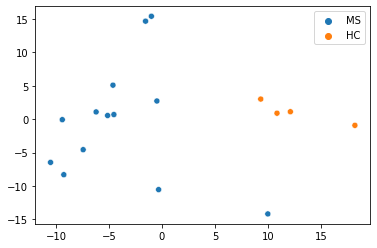

In [126]:
sns.scatterplot(x=pca_coord[:, 0], y=pca_coord[:, 1], hue=cond_vec)
plt.show()

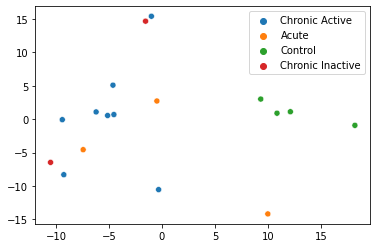

In [127]:
inf_stage = np.array([sample_lesion_dict[sample] if sample in sample_lesion_dict.keys() else "NA" for sample in adata_dict.keys()])
sns.scatterplot(x=pca_coord[:, 0], y=pca_coord[:, 1], hue=inf_stage)
plt.show()

In [181]:
image_features_mtx = np.vstack([adata.obsm["image_features"] for adata in adata_dict.values()])
image_features_adata = scanpy.AnnData(image_features_mtx)
image_features_adata.obs = pd.concat([adata.obs for adata in adata_dict.values()])
image_features_adata.obs["sample_id"] = np.hstack([np.repeat(sample, len(adata_dict[sample])) for sample in samples])
image_features_adata.obs["lesion_type"] = image_features_adata.obs["sample_id"].map(sample_lesion_dict)
sc.pp.pca(image_features_adata)
sc.external.pp.bbknn(image_features_adata, batch_key="sample_id") # maybe this integration step helps
# sc.pp.neighbors(image_features_adata) # this is the alternaive
image_features_adata

AnnData object with n_obs × n_vars = 56287 × 2048
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow', 'tile_path', 'sample_id', 'lesion_type'
    uns: 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [182]:
sc.tl.leiden(image_features_adata, resolution=2)
image_features_adata

AnnData object with n_obs × n_vars = 56287 × 2048
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow', 'tile_path', 'sample_id', 'lesion_type', 'leiden'
    uns: 'pca', 'neighbors', 'leiden'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [183]:
# count number of cells per cluster per sample
cluster_counts = image_features_adata.obs.groupby(["sample_id", "leiden"]).size().reset_index()
cluster_counts = cluster_counts.pivot(index="sample_id", columns="leiden", values=0)
cluster_counts = cluster_counts.fillna(0)
cluster_counts = cluster_counts.div(cluster_counts.sum(axis=1), axis=0)

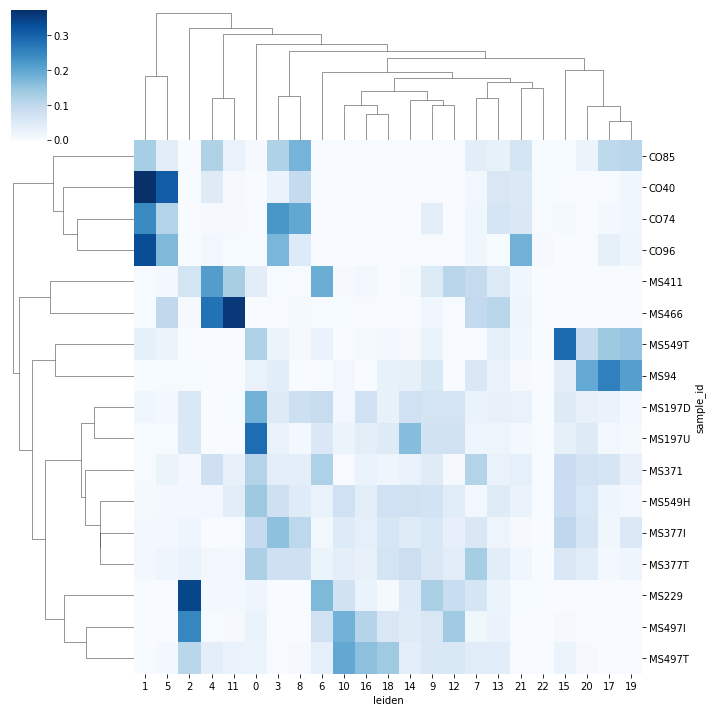

In [184]:
# heatmap with hierarchical clustering
sns.clustermap(cluster_counts, cmap="Blues")
plt.show()

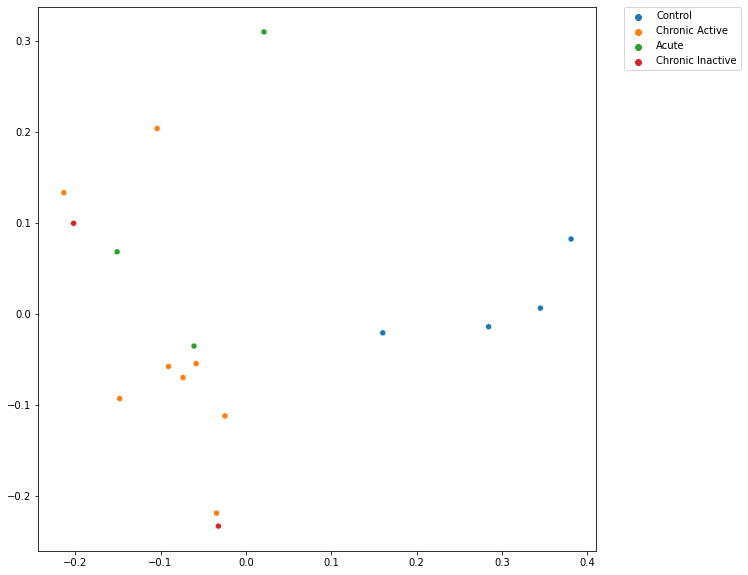

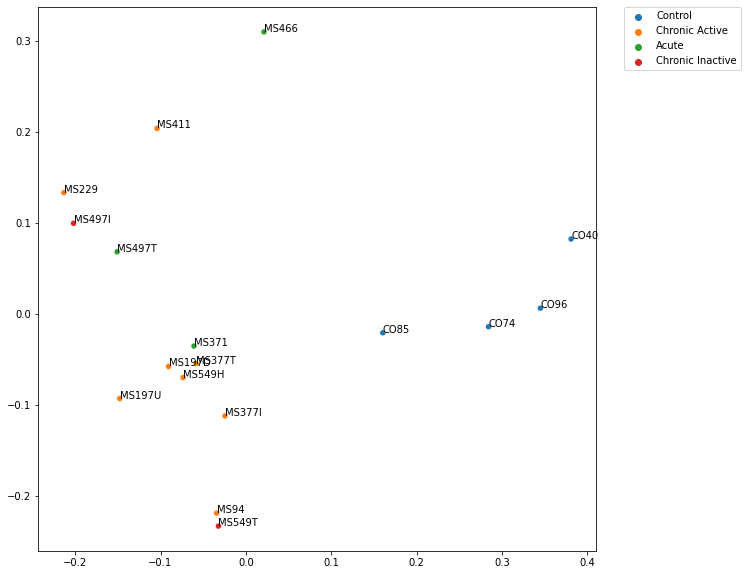

In [185]:
pca_coord_3 = PCA(n_components=min(cluster_counts.shape)).fit_transform(cluster_counts)

# same plot as above but label the points using the cluster_counts.index by writing the text in the plot
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x=pca_coord_3[:, 0], y=pca_coord_3[:, 1], hue=[sample_lesion_dict[s] for s in cluster_counts.index])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# same plot as above but label the points using the cluster_counts.index by writing the text in the plot
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x=pca_coord_3[:, 0], y=pca_coord_3[:, 1], hue=[sample_lesion_dict[s] for s in cluster_counts.index])
for i, txt in enumerate(cluster_counts.index):
    plt.annotate(txt, (pca_coord_3[i, 0], pca_coord_3[i, 1]))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()